In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/WirelessMLCodes/CEL_SS/2023SPRVersion')

In [2]:
'''
2024 Feb version. model pre-trained on normal 2xdata, tested with PUs using Random Mod type '''
import torch
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import math
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.distributed as TUDdistributed
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import sys
from copy import deepcopy
import pandas as pd
import random
import collections
#from MobileNetV1_CriticalPath import Net
import matplotlib.pyplot as plt
# from sklearn.externals import joblib
from cnn_models import standalone_cnn
from cnn_models import decouple_cnn
#from drive.MyDrive.WirelessMLCodes.CEL_SS.2023SPRVersion.cnn_models import normal_cnn

from pytz import timezone
TMZ = timezone('EST')
import datetime
import shutil
import time

device = torch.device("cuda")
use_cuda = True
criterion = nn.CrossEntropyLoss()

random.seed(0)

        

def create_net(chn_list, per_class_filter, ty_chs):
    number_class = len(chn_list) # tol_class num is 3
    d_w = number_class*per_class_filter
    cfg = [40, d_w, d_w, d_w ]
    print('corresponding cfg channel list:',cfg)
    # net = ensemble_vgg(dataset=number_class, cfg = cfg) 
    net = standalone_cnn(nch = number_class, cfg=cfg, ty_chs=ty_chs)
    net.to(device)
    return net

def testnetsVote(model_list, class_dir, test_loader, coef_list, gain_dif, thresh_sig = 0.5):                             
    '''default for FL CEL stdaln, Tests all nodes together, apply majority vote for each band 
    '''
    total = 0 #sum of occupation and emptiness
    test_loss = 0 
    total_ocp = 0 #occupied bands
    total_emp = 0 #empty bands
    correct = 0
    total_cmb = 0  #occupation combination
    correct_ocp = 0
    correct_emp = 0
    correct_cmb = 0
    thresh_logit = -1*(math.log(thresh_sig**(-1) -1))
    # thresh_logit = thresh_sig
    
    with torch.no_grad():
        criterion = nn.BCEWithLogitsLoss()
        for batchidx, (data, target) in enumerate(test_loader):
            target =  target.cuda()
            #print(target.size())
            target = Variable(target)
            target = Variable(target)
#             print('target size is:',target.size())
            output_manual = torch.zeros(target.shape) # manual global decision, float version
            total_batch = float(torch.tensor(target.size()).prod()) #total num of channels in this batch
            total += total_batch
            total_cmb += float(target.size(0))
            total_ocp += float(target.sum())
            total_emp += float(total_batch - target.sum()) 
            if (1-target).sum() != (torch.tensor(target.size()).prod() - target.sum()) : #Testing tensor dim =========
                print('show difference:',(1-target).sum(), total - target.sum())
                print('total ocp/emp calculation wrong')
            '''Above calculate the total number of channels detected and the ground truth number of occupation/emptiness'''
            coef = torch.tensor(coef_list)
            for idx in range(len(class_dir)): # appply fusion strategy on local_node detections
                model_list[idx].eval()
                datain = Variable(gain_dif*1e7*data[idx]).cuda() #1e7 to boost gradient
                localout = (model_list[idx](datain).cpu()>thresh_logit).float()
                output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]].add_(localout) #add local detection result
                # output_manual[:,class_dir[idx]] = output_manual[:,class_dir[idx]]|(model_list[idx](datain).cpu()>thresh_logit)
            out_WOnorm = output_manual
            output_manual = output_manual.div_( coef ) > 0.49 #get fusion decision
            if batchidx == -1 :
                id = 90
                print('label:',target[id])
                print('un-normalized fusion:', torch.norm(out_WOnorm))
                print('SU fusion:',output_manual[id])

            

            correct_ocp += (output_manual*target.cpu()).sum()
            correct_emp += ((~output_manual)*(1-target.cpu())).sum()
            correct_cmb += (~(output_manual^( target.bool().cpu() ))).float().prod(1).sum() #use XNOR which is 'not+XOR'

            loss = criterion(output_manual.float().cuda(), target)
            test_loss += loss.item()
            # print(output, loss.item())

        correct_tol = deepcopy(correct_ocp) + deepcopy(correct_emp) #just sum
        accuracy_tol = 100*correct_tol/total
        accuracy_pd = 100*correct_ocp/total_ocp
        accuracy_pfa = 100*correct_emp/total_emp
        accuracy_cmb = 100*correct_cmb/total_cmb

    loss = loss.item()
    print('test last batch',(~(output_manual^target.bool().cpu())).float().prod(1).sum() / target.size(0))
    print('++++++++++++++++++ Accuracy on global set: total: %d %%, combination: %d %%, PD: %d %%, PFA: %d %%, loss: %.3f' \
                                            % ( accuracy_tol, accuracy_cmb, accuracy_pd, 100-accuracy_pfa, loss))
    return (accuracy_tol, accuracy_pd, 100-accuracy_pfa)


def shared_ch(class_dir, idx):
    '''idx-th local dataset, find the shared channel with each nearby local models(idx-1 and idx+1) 
    and the corresponding ouput logit position at nearby models'''
    out_chn_idx = []#list of tuples
    #the channel each neighbor detects and the model output of each neighbor for this channel
    for neighbor in [class_dir[idx-1], class_dir[(idx+1)%len(class_dir)]]:
        for ch in class_dir[idx]:  
            if ch in neighbor:
                out_chn_idx.append((ch, neighbor.index(ch))) #should be only one for each neighbor
    
    return out_chn_idx


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    epoch_inter = 30
    bs = 0.2
    # bs = 1
    lr = 0.05 * bs ** (epoch//epoch_inter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(model, epoch, class_list, train_loader, thresh_sig = 0.5):
    '''Use NodeDatasetMaker by default, trainloader only gives local data and only trains a local model'''
    # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    # optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5) # use ADAM for standalone
    adjust_learning_rate(optimizer, epoch)
#     print("\nLocal Epoch", epoch)
    sys.stdout.flush()

    for param_group in optimizer.param_groups:
        print('Learning Rate: %f' % param_group['lr'])
    # sys.stdout.flush()
    model.train()
    thresh_logit = -1*(math.log(thresh_sig**(-1) -1))
#     print('threshold on output logits', thresh_logit)
    train_loss = 0
    criterion = nn.BCEWithLogitsLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()     
        #print( data.size() )
        data, target = Variable(1e7*data), Variable(target)

        optimizer.zero_grad()
        #output = model(data, len(class_list))
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()#remains to be edited
    return model

def gather_layer(model): # Gather layers of a model to 3 categories: convlist, batchnormlist, fclist
    convlist = []
    batchnormlist= []
    fclist =[]
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            convlist.append(layer)
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.GroupNorm):
            batchnormlist.append(layer)
    fclist.append(model.fc)
    return convlist, batchnormlist, fclist



"""626/720 dataset maker, each logit corresponds to the occupation of a single channel"""
class TotalDatasetMaker(Dataset):
    "simple version that requires the user to edit input/label format elsewhere"
    def __init__(self, db, label_list, transformFunc ):
        """
        db: a list of input signal tensors, label_list: a list of data labels, corresponding to db.
        """
        self.datasets = db
        self.label_list = label_list
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        img = self.datasets[i]
        img = self.transformFunc(img)
        class_label = self.label_list[i]
        return img, class_label

    def __len__(self):
        return len(self.label_list)
    
    
"""720 dataset maker, data looks like: each global channel occupation condition ==> 
each node only learn from 'local' received signal(full size for each node) which is an element in the list of this condition """
class NodeDatasetMaker(Dataset):

    def __init__(self, db, label_list, node, class_dir, transformFunc ):
        """
        db: a list of input signal tensors, label_list: a list of data labels, corresponding to db.
        node
        """
        self.datasets = db
        self.label_list = label_list
        self.transformFunc = transformFunc
        self.chn_list = class_dir[node]
        self.node = node
    def __getitem__(self, i):
        img = self.datasets[i][self.node]
        img = self.transformFunc(img)
        class_label = self.label_list[i][self.chn_list]
        return img, class_label

    def __len__(self):
        return len(self.label_list)
    
def Dis_analysis(class_dir, tol_list):
  #idx_list: list of lists, global positions of locally observable bands for each node
  #coef_list: coef for averaging the param for each band, how many nodes are learning each certain band
    idx_list = []
    coef_list = [0]*len( tol_list )
    for i in range( len(class_dir) ): #Generating the mapping btw nodes and net_tol
        sub_idx_list = [] 
        for j in class_dir[i]:
            for k in range( len(tol_list) ):
                if j == tol_list[k]:
                    sub_idx_list.append(k)
                    coef_list[k] += 1 
                    break
        idx_list.append(sub_idx_list)
    return idx_list, coef_list

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    print('Directory already exists')
    shutil.rmtree(filepath, ignore_errors = True)
    os.mkdir(filepath)


/tmp/ipykernel_3769081/3778795613.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]] [2, 3, 2, 2, 6, 6, 2, 2, 3, 2, 3, 2, 2, 6, 2, 2, 3, 2, 2, 6]
corresponding cfg channel list: [40, 32, 32, 32]
corresponding cfg channel list: [40, 40, 40, 40]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 56, 56, 56]
corresponding cfg channel list: [40, 64, 64, 64]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding cfg channel list: [40, 56, 56, 56]
corresponding cfg channel list: [40, 48, 48, 48]
corresponding 

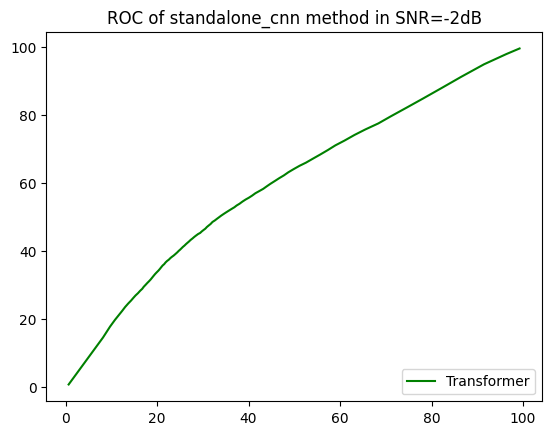

ROC in Excel saved to: Saved_Models/SwitchPU/standalone_cnn/SNRs/-2dBVol20_240210_00_32/ROC_SNR-2.xlsx
ROC in Lists saved to: Saved_Models/SwitchPU/standalone_cnn/SNRs/-2dBVol20_240210_00_32/standalone_cnnROC.pth


In [3]:
for snr in [2]: # [2, 4, 6, 8, 10, 12, 14, 16] [ 4, 12, 14] [8, 14, 16, 20, 6 ]: #[12, 8, 14, 16, 20]: #[12, 8 ]: #[12, 8, 14, 16, 20]

    # Load data =========================================================================================================
    roc_dots = 100
    nepoch = 0
    volum = 20
    SNR= -1*snr
    DistAmp_tr = 10 # DistAmp = 10 #25
    DistAmp_te = 10 #25    
    alpha_tr = 3.71
    alpha_te = 3.71
    gain_dif= (DistAmp_te*2*3**0.5 /3)**alpha_te / (DistAmp_tr*2*3**0.5 /3)**alpha_tr
    # gain_dif= (DistAmp_te/DistAmp_tr)**3.71
    stage_dir='/SNRs/'#for naming and directory
    # datadir_tr = 'RefinedNewData/SNRs/'+str(DistAmp_tr)+'m/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir_te = 'RefinedNewData/SNRs/'+str(DistAmp_te)+'m/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir_te = 'RefinedNewData/SNRs/'+str(DistAmp_te)+'m_Alpha5/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    # datadir = 'RefinedNewData/SNRs/RandMod/Data_SNR'+str(SNR)+'vol1'+'.pth' # RandMod: revision dataset, PU mod varying (testing data only)
    datadir = 'RefinedNewData/SNRs/PUswitch/Data_SNR'+str(SNR)+'vol1.pth'
    datadir_te = datadir
    datadir_tr = datadir
    Model_dir = 'Saved_Models/standalone_cnn/LoadedModel/'+str(SNR)+'dBVol20'

    data_dict_tr = torch.load(datadir)
    data_dict_te = torch.load(datadir)
    data_dict_tr.keys()

    db = data_dict_tr['training data list']
    label_list = data_dict_tr['training label list']

    db_te = data_dict_te['testing data list']
    label_list_te = data_dict_te['testing label list']

    # Create CNN =========================================================================================================

    per_class_filter = 8
    shared_layers = 1 # not used
    class_dir=[[0, 3, 4, 19], [0, 1, 10, 4, 19], [1, 10, 4, 19, 5, 13], [1, 10, 2, 11, 14, 5, 13], [2, 11, 14, 5, 13, 6, 15, 17], [3, 4, 19, 7, 12, 18], [4, 19, 7, 12, 18, 8, 16], [4, 19, 5, 13, 8, 16], [5, 13, 8, 16, 9], [5, 13, 6, 15, 17, 9]]

    tol_list = []
    for classi in class_dir:
      tol_list += classi
    tol_list = list( set(tol_list) )
    tol_list.sort()

    print(class_dir)
    print(tol_list)

    idx_list, coef_list = Dis_analysis(class_dir, tol_list)
    print(idx_list, coef_list)

    #Parepare nets
    net_list = []
    # net_tol = create_net(tol_list, per_class_filter, False) #No total net
    Acc_tol=[]
    # Acc_list = []

    for i in range(len(class_dir)):
        net_list.append(create_net(class_dir[i], per_class_filter, True))
        # Acc_list.append([])

    db_tr_list = []
    for idx in range(len(class_dir)):# train datasets are more complex
        db_tr_list.append(NodeDatasetMaker( db, label_list, idx, class_dir, transforms.Compose([ ]) ))
    db_te_1 = TotalDatasetMaker( db_te, label_list_te, transforms.Compose([ ]) )

    train_loader_list = []
    for idx in range(len(class_dir)):# trainloaders are more complex
        train_loader_list.append(DataLoader(db_tr_list[idx], batch_size=100, shuffle=True, num_workers=4, pin_memory=True))
    tol_test_loader = DataLoader(db_te_1, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True)

    # aggre_inter = 1 #currently unused

    now=datetime.datetime.now(TMZ) #time watermark
    time_watermark = now.strftime('%y%m%d_%H_%M')
    print('model watermark',time_watermark)
    # /content/drive/MyDrive/WirelessMLCodes/CEL_SS/2023SPRVersion
    address_model = 'Saved_Models/SwitchPU/'+type(net_list[0]).__name__+stage_dir+str(SNR)+'dBVol'+str(volum)+'_'+time_watermark+'/' #root dir for saved models
    #child dir nbamed by time_watermark
    setDir(address_model+'checkpoint/') # if dir not exist, create. if dir already exist, empty it.
    setDir(address_model+'bestmodel/')
    # name1 = type(v).__name__ +'_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
    print('Models saved to dir:\n', address_model)
    name0 = type(net_list[0]).__name__ +'_SNR'+str(SNR)+'vol'+str(volum) # common part of DNN node names

    # for i in range(len(net_list)):
    #   name1 = name0+'node'+str(i)
    txt=open(address_model+'Datasetdir.txt',"w").write(datadir_te) #save dataset dir (dataset version)

    # Train =========================================================================================================
    Acc_PD = []
    Acc_PFA = []
    Acc_cmb = []
    Acc_tol = []
    plt.title("Global Model ACC of the proposed method")
    best_acc = 0
    Acc_tol.append( testnetsVote( net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig = 0.5 )[0].item() )
    for epoch in range(nepoch):
        time_start = time.time()
        # Train & save dicts of n1 n2
        print('epoch:',epoch)
        for i in range(len(net_list)):
            net_list[i] = train(net_list[i], epoch, class_dir[i], train_loader_list[i])
            name1 = address_model+'checkpoint/'+name0+ '_node' +str(i)+ '.pth'
            torch.save(net_list[i].state_dict(), name1)
        best_acc = max(Acc_tol)
    #     Acc_tol.append( testnets( net_list, class_dir, tol_test_loader )[0]  )
        # Acc_tol.append( test_exchange( net_list, class_dir, tol_test_loader, thresh_sig = 0.5  )[0]  )
        # Acc_tol.append( testnets( net_list, class_dir, tol_test_loader, thresh_sig = 0.5  )[0].item()  )
        Acc_tol.append( testnetsVote(net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig = 0.5)[0].item() )
        print('Saving..')
        state = {
            'net': [net.state_dict() for net in net_list],
            'acc': Acc_tol[-1],
            'epoch': epoch,
        }
        if Acc_tol[-1] > best_acc:
            # torch.save(state, './bestmodel/standalone135_Jan2022.pth')
            for i in range(len(net_list)):
                name1 = address_model+'bestmodel/'+name0+ '_node' +str(i)+ '.pth'
                torch.save(net_list[i].state_dict(), name1)
            best_acc = 1*Acc_tol[-1]

        #plt.title("Training and Testing Acc at Learning Rate %s"%LR)
        plt.figure(1,figsize=(5, 4), dpi=80)
        l1, = plt.plot( Acc_tol, color='blue', label='Avg Acc/band')
        l2, = plt.plot( Acc_PFA, color='red', label='Acc 4 empty')
        l3, = plt.plot( Acc_PD, color='black', label='Acc 4 busy')
        # l4, = plt.plot( Acc_cmb, color='green', label='Acc 4 Combine')
        plt.title('SNR='+str(SNR)+'dB,'+ type(net_list[0]).__name__+ ' Model ACC reaches %.3f %%' %  (max(Acc_tol))  )
        plt.legend(loc='lower right')
        plt.show()

        plt.figure(2,figsize=(5, 4), dpi=80)
        l1, = plt.plot( Acc_tol, color='blue',label='Avg Acc/band')
        plt.legend(loc='lower right')
        plt.title('SNR='+str(SNR)+'dB,'+ type(net_list[0]).__name__+ ' Model ACC reaches %.3f %%' %  (max(Acc_tol))  )
        plt.show()
        
        time_end=time.time()
        print('1 epoch time cost:',time_end-time_start,'s')

    for i in range(len(net_list)):
        net_list[i].load_state_dict(torch.load(Model_dir+'/bestmodel/'+name0+'_node'+str(i)+'.pth'))
    print('best models loaded')

    df1 = pd.DataFrame()
    # df1['acc_old'] = xx
    df1['Accuracy'] = Acc_tol

    with pd.ExcelWriter(address_model + "converg"+"SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
        df1.to_excel(writer, sheet_name=type(net_list[0]).__name__)
    print('statics saved to excel:', address_model + "converg"+"SNR"+str(SNR)+".xlsx")

    # ROC =========================================================================================================
    '''ROC module of current standalone model, saved in pd2 and pfa2'''
    pd2= []
    pfa2 = []

    # for thresh_val in [ (i-50)/12.5 for i in range(100)]: 
    # for thresh_val in [ (i+.01)/100 for i in range(100)]: # 0.5~99.5/100
    # for thresh_val in [ 1/(1+np.exp(-(i-int(roc_dots/2))/3.125)) for i in range(roc_dots)]:
    for thresh_val in [ (i+.99999)/100 for i in range(100)]:
      #[i*0.9999/100 for i in list(range(1,100))]
      # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
        print('threshold:', thresh_val)
        CNNoutput = testnetsVote(net_list, class_dir, tol_test_loader, coef_list, gain_dif, thresh_sig=thresh_val) #
        # testnets( net_list, class_dir, tol_test_loader, thresh_sig = 0.5  )
        #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
        pd2.append(CNNoutput[1].to(torch.device('cpu')).item())
        pfa2.append(CNNoutput[2].to(torch.device('cpu')).item())

    plt.title("ROC of " +type(net_list[0]).__name__+ " method in SNR="+str(SNR)+"dB")
    l2, = plt.plot(pfa2, pd2, color='green', label='Transformer')
    plt.legend(loc='lower right')
    plt.show()

    dfroc = pd.DataFrame() # save statics to excel
    # df1['acc_old'] = xx
    dfroc['PFA'] = pfa2
    dfroc['PD'] = pd2
    
    with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
      dfroc.to_excel(writer, sheet_name=type(net_list[0]).__name__)
    print('ROC in Excel saved to:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

    ROC_dict = {
        'pd':pd2,
        'pfa':pfa2,
    }
    torch.save(ROC_dict, address_model+type(net_list[0]).__name__+'ROC.pth')
    print('ROC in Lists saved to:', address_model+type(net_list[0]).__name__+'ROC.pth')

In [4]:
from torchsummary import summary 
# v = AlexNet1D(num_classes = 10).to(device)
summary(net_list[0], (1,64,20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 64, 20]             400
       BatchNorm2d-2           [-1, 40, 64, 20]              80
              ReLU-3           [-1, 40, 64, 20]               0
            Conv2d-4           [-1, 32, 64, 20]          11,552
       BatchNorm2d-5           [-1, 32, 64, 20]              64
              ReLU-6           [-1, 32, 64, 20]               0
         MaxPool2d-7           [-1, 32, 16, 20]               0
            Conv2d-8           [-1, 32, 16, 20]           9,248
       BatchNorm2d-9           [-1, 32, 16, 20]              64
             ReLU-10           [-1, 32, 16, 20]               0
        MaxPool2d-11            [-1, 32, 8, 10]               0
           Conv2d-12            [-1, 32, 8, 10]           9,248
      BatchNorm2d-13            [-1, 32, 8, 10]              64
             ReLU-14            [-1, 32

In [5]:
import sys

# To stop the kernel using sys.exit()
sys.exit()

# To stop the kernel using KeyboardInterrupt
raise KeyboardInterrupt

SystemExit: 

/home/wzhang23/.conda/envs/Partial_Observ/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#To shutdown workspace
from google.colab import runtime
runtime.unassign()

ModuleNotFoundError: No module named 'google'

In [ ]:
saved_nets = torch.load('./bestmodel/standalone135.pth')['net']

for j in range(len(class_dir)):
    net_list[j].load_state_dict(saved_nets[j])
print('best models loaded')
test_exchange( net_list, class_dir, tol_test_loader, thresh_sig = 0.5 )[0]  #thresh_sig = 0.1

In [ ]:
saved_nets = torch.load('./bestmodel/standalone135_Jan2022.pth')['net']
# saved_nets = torch.load('./bestmodel/standalone120_Jan2022.pth')['net']
for j in range(len(class_dir)):
    net_list[j].load_state_dict(saved_nets[j])
print('best models loaded')

In [ ]:
# data_dict = torch.load('CSS_103_5_test.pth')
data_dict = torch.load('CSS_1029_120db.pth')

db = data_dict[ 'train_data']
label_list = data_dict['train_label']
db_te = data_dict[ 'test_data']
label_list_te = data_dict['test_label']
'''For quickly find PD at PFA = 5%. Must redo datasets and loaders'''
db_te_1 = TotalDatasetMaker( db_te, label_list_te, transforms.Compose([ ]) )
tol_test_loader = DataLoader(db_te_1, batch_size=100, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
'''For quickly find PD at PFA = 5%'''

Acc_PD = []
Acc_PFA = []
Acc_cmb = []
test_standalone_thresh( net_list, class_dir, tol_test_loader, thresh_logit = 59 )[0] #0.99999999999999983